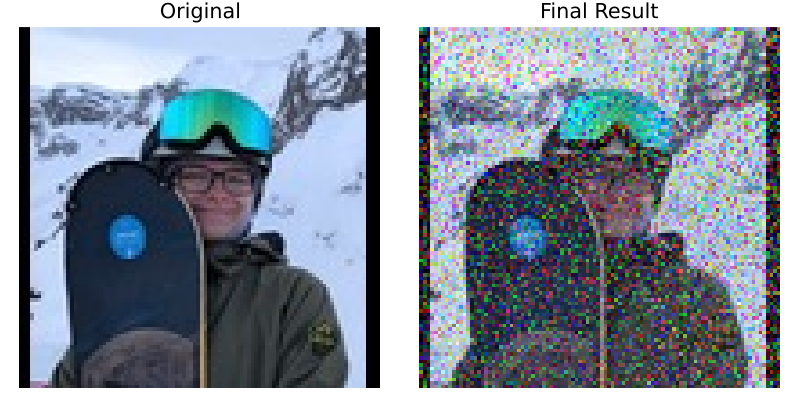

┌ Info: Saved animation to /Users/d.okutin/evolution.gif
└ @ Plots /Users/d.okutin/.julia/packages/Plots/kLeqV/src/animation.jl:156


In [9]:
using Random, Plots, Images, FileIO

# Загрузка и подготовка изображения
target_image = load("input.jpg")
target_image = Float64.(channelview(RGB.(target_image)))

# Сохраняем оригинальное изображение для отображения
original_image = colorview(RGB, target_image)

function image_to_vector(img)
    return vec(reshape(img, :))
end

function vector_to_image(vec, height, width)
    reshaped = reshape(vec, 3, height, width)
    return colorview(RGB, reshaped)
end

# Модифицированная функция для отрисовки двух изображений
function plot_comparison!(gen_vec, anim, height, width, gen, fintess)
    generated_img = vector_to_image(gen_vec, height, width)
    
    p = plot(
        plot(original_image, title="Оригинал ", axis=false, ticks=false, border=false),
        plot(generated_img, title="Поколение $gen - Расстояние $fintess", axis=false, ticks=false, border=false),
        layout = (1, 2),
        size = (800, 400)
    )
    
    frame(anim, p)
end

# Функция для финального сравнения
function plot_final_comparison(best_vec, height, width)
    generated_img = vector_to_image(best_vec, height, width)
    
    p = plot(
        plot(original_image, title="Original", axis=false, ticks=false, border=false),
        plot(generated_img, title="Final Result", axis=false, ticks=false, border=false),
        layout = (1, 2),
        size = (800, 400)
    )
    display(p)
end

# Остальные функции остаются без изменений
function initialize_population(size, dims)
    return [rand(Float64, dims) for _ in 1:size]
end

function fitness(candidate, target)
    return -sum((candidate .- target).^2)
end

function crossover(p1, p2)
    point = rand(1:length(p1)-1)
    return vcat(p1[1:point], p2[point+1:end])
end

function mutate(child, mutation_rate)
    for i in eachindex(child)
        if rand() < mutation_rate
            child[i] += randn() * 0.05
            child[i] = clamp(child[i], 0.0, 1.0)
        end
    end
    return child
end

function select_parents(population, target, num_parents)
    sorted = sort(population, by = x -> fitness(x, target), rev = true)
    return sorted[1:num_parents]
end

function genetic_algorithm(target_vec, height, width; pop_size=50, generations=500, mutation_rate=0.05, save_path="evolution.gif")
    population = initialize_population(pop_size, length(target_vec))
    anim = Animation()

    best_match_per_pixel = copy(population[1])
    best_error_per_pixel = abs.(best_match_per_pixel .- target_vec)

    for gen in 1:generations
        # Отрисовываем сравнение с оригиналом
        plot_comparison!(best_match_per_pixel, anim, height, width, gen, fitness(best_match_per_pixel,target_vec))
        
        parents = select_parents(population, target_vec, 4)
        offspring = []
        while length(offspring) < pop_size
            p1, p2 = rand(parents, 2)
            child = crossover(p1, p2)
            push!(offspring, mutate(child, mutation_rate))
        end

        population = offspring
        current_best = select_parents(population, target_vec, 1)[1]

        current_error = abs.(current_best .- target_vec)
        for i in eachindex(current_error)
            if current_error[i] < best_error_per_pixel[i]
                best_match_per_pixel[i] = current_best[i]
                best_error_per_pixel[i] = current_error[i]
            end
        end
    end

    gif(anim, save_path, fps=20)
    return best_match_per_pixel
end

# Запуск алгоритма
height, width = size(target_image)[2], size(target_image)[3]
target_vec = image_to_vector(target_image)

best_match = genetic_algorithm(target_vec, height, width)